## Setup

In [1]:
import copy
from datetime import datetime
from FireSimulator import *
from FireSimulatorUtilities import *
import glob
import itertools
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import time
import timeit

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Oracle solution

Benchmark oracle solution by running many simulations

In [140]:
# simulator parameters
grid_size = 50
dp = 0.15/0.2763
repeat_ctr = 1
repeat_lim = 6
center = (grid_size+1)/2

# agent initialization parameters
spawn_loc = np.arange(grid_size//3//2,grid_size,grid_size//3)
perturbs = np.arange(-grid_size//3//2+1,grid_size//3//2+1,1)

fire_neigh = [(-1,0),(1,0),(0,-1),(0,1)]

In [153]:
seeds = range(1000)

results = []

In [154]:
tic = time.clock()
for i,s in enumerate(seeds):
    np.random.seed(1000+s)

    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    sim.step([]) # start fire in domain

    # initialize agent position
    n = 10
    agent_pos = np.random.choice(spawn_loc, (n,2)) + np.random.choice(perturbs, (n,2))
    agent_pos = np.squeeze(agent_pos).astype(np.int32)
    agent_data = {}
    for k in range(n):
        agent_data[k] = {}
        agent_data[k]['sf'] = False

    control = []
    repeat_ctr = 1

    new_agent_pos = np.zeros((n,2)).astype(np.int32)
                    
    bdry = []
    #for (x,y) in sim.fires:
    for r in range(grid_size):
        for c in range(grid_size):
            if sim.state[r,c] in [1,2]:
                ctr = 0
                for (dr,dc) in fire_neigh:
                    rn = r + dr
                    cn = c + dc
                    if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and sim.state[rn,cn] in [0]:
                        ctr += 1
                        break
                        
                if ctr>0:
                    x = col_to_x(c)
                    y = row_to_y(grid_size,r)
                    bdry.append((x,y))

        #ctr = 0
        #r = y_to_row(grid_size,y)
        #c = x_to_col(x)
        #for (dr,dc) in fire_neigh:
        #    rn = r + dr
        #    cn = c + dc
        #    if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and sim.state[rn,cn] in [0]:
        #        ctr += 1
        #        break

        #if ctr > 0:
        #    bdry.append((x,y))  
                      
    while not sim.end:
        # calculate action for each agent
        for k in range(n):
            img, img_st, _ = CreateImageBW(sim.state, agent_pos[k,:])
            if img_st[8//2,8//2] in [1,2]:
                agent_data[k]['sf'] = True                

            if not agent_data[k]['sf']:
                dists = []
                for a in range(9):
                    new_pos = actions_to_trajectory(agent_pos[k,:],[a])[1]
                    dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1]),new_pos,a))
                    
                _, new_pos, action = min(dists)
                traj = []
                traj.append((agent_pos[k,:][0],agent_pos[k,:][1]))
                traj.append((new_pos[0],new_pos[1]))
                    
                #control.extend(FindGridIntersections(sim.state, traj))
                new_agent_pos[k,:] = [traj[-1][0], traj[-1][1]]
                    
            else:
                #if not bdry:
                #    continue

                #idxs = np.random.choice(len(bdry), replace=True)
                #control.extend(bdry[idxs])
                
                new_agent_pos[k,:] = agent_pos[k,:]

        # generate control from trajectory
        # control = list(set(control))

        # update simulator periodically                
        if repeat_ctr % repeat_lim == 0:
            ctr = 0
            for k in range(n):
                if agent_data[k]['sf']:
                    ctr += 1
                    
            if ctr>0 and len(bdry) <= ctr*repeat_lim:
                control = bdry
            elif ctr>0:
                idxs = np.random.choice(len(bdry), size=ctr*repeat_lim, replace=True)
                for j in idxs:
                    control.append(bdry[j])
               
            control = list(set(control))
            
            #print(ctr," ",len(control)," ",len(bdry)," ",sim.stats)
            sim.step(control, dbeta=dp)
            control = []
            
            bdry = []
            #for (x,y) in sim.fires:
            for r in range(grid_size):
                for c in range(grid_size):
                    if sim.state[r,c] in [1,2]:
                        ctr = 0
                        for (dr,dc) in fire_neigh:
                            rn = r + dr
                            cn = c + dc
                            if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and sim.state[rn,cn] in [0]:
                                ctr += 1
                                break

                        if ctr>0:
                            x = col_to_x(c)
                            y = row_to_y(grid_size,r)
                            bdry.append((x,y))
            
                
        repeat_ctr += 1

        # update agent position
        agent_pos = new_agent_pos
        new_agent_pos = np.zeros((n,2)).astype(np.int32)

    if (i+1) % 10 == 0:
        print("finished %d simulations" % (i+1))
    
    # store simulation result
    results.append(sim.stats[2]/np.sum(sim.stats)) # fraction of burned trees

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

finished 10 simulations
finished 20 simulations
finished 30 simulations
finished 40 simulations
finished 50 simulations
finished 60 simulations
finished 70 simulations
finished 80 simulations
finished 90 simulations
finished 100 simulations
finished 110 simulations
finished 120 simulations
finished 130 simulations
finished 140 simulations
finished 150 simulations
finished 160 simulations
finished 170 simulations
finished 180 simulations
finished 190 simulations
finished 200 simulations
finished 210 simulations
finished 220 simulations
finished 230 simulations
finished 240 simulations
finished 250 simulations
finished 260 simulations
finished 270 simulations
finished 280 simulations
finished 290 simulations
finished 300 simulations
finished 310 simulations
finished 320 simulations
finished 330 simulations
finished 340 simulations
finished 350 simulations
finished 360 simulations
finished 370 simulations
finished 380 simulations
finished 390 simulations
finished 400 simulations
finished 

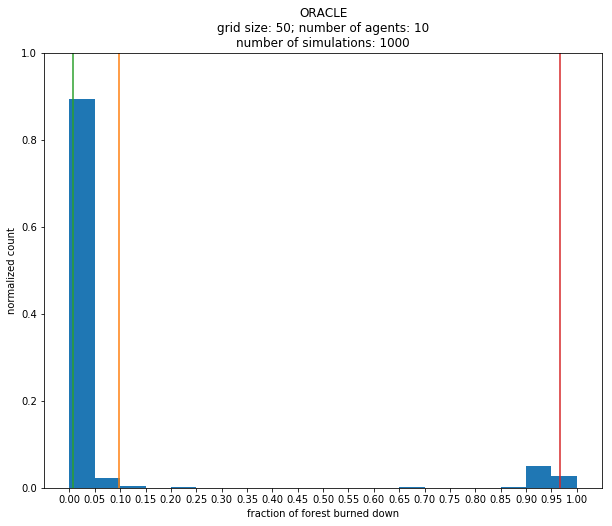

In [158]:
plt.figure()
weights = np.ones_like(results)/float(len(results))
splits, _, _ = plt.hist(results, bins=np.arange(0,1+0.05,0.05), normed=False, weights=weights)
plt.axvline(np.mean(results),color="C1",label="mean")
plt.axvline(np.percentile(results,0),color="C2",label="min")
plt.axvline(np.percentile(results,100),color="C3",label="max")

plt.ylim([0,1])
plt.xticks(np.arange(0,1+0.05,0.05))
plt.xlabel('fraction of forest burned down')
plt.ylabel('normalized count')
plt.title('ORACLE\ngrid size: %d; number of agents: %d\nnumber of simulations: %d' %(grid_size,n,len(results)))
# plt.legend(loc=1)

plt.savefig('oracle.png', bbox_inches='tight')

In [159]:
splits

array([ 0.893,  0.022,  0.004,  0.   ,  0.001,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.001,  0.   ,  0.   ,
        0.   ,  0.001,  0.05 ,  0.028])

In [160]:
np.mean(results)

0.097791200000000009